This notebook will utilize the MNIST dataset to aid in training a neural network (NN) that can recognize digits. Its performance will then be test on some Sudoku puzzles, but it is expected as of now that it may not be perfect since this dataset containts handwritten digits. Sudoku puzzles are typically printed in a nicer fashion. Therefore, it may be wise to explore and expand the training dataset to also incorporate printed Sudoku puzzles. This may make it easier for the NN to then recognize puzzles that have been printed and partially filled in. 

In [19]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import cv2
from PIL import Image
from copy import copy
import re
import os

In [20]:
def detectSudokuPuzzle(image_path, silent=True):
    original_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    colored_image = copy(original_image)
    gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    img_width = gray_image.shape[1]
    img_height = gray_image.shape[0]

    if not silent:
        print(f"Shape of image: {img_width}, {img_height}")

    modified_image = cv2.medianBlur(gray_image, 3)
    modified_image = cv2.adaptiveThreshold(modified_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    modified_image = cv2.Canny(modified_image, 250, 200)
    modified_image = cv2.dilate(modified_image, np.ones((3,3), np.uint8), np.zeros(gray_image.shape), [-1,1])

    contours, _ = cv2.findContours(modified_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # sort by the largest contour
    contour_areas = np.array([cv2.contourArea(cont) for cont in contours])
    area_indices = np.flip(np.argsort(contour_areas))

    # Just to analyze the area of the largest contour
    largest_area = contour_areas[area_indices[0]]
    total_area = img_width * img_height

    # filter out contours whose area is nearly the entire image
    # which would indicate that there is a border around the image
    l_i = 0
    area_threshold = 0.98
    for i, area_idx in enumerate(area_indices):
        curr_area = contour_areas[area_idx]
        if curr_area / total_area < area_threshold:
            l_i = i
            break
    area_indices = area_indices[l_i:]

    # for i in range(len(area_indices)):
    perimeter = cv2.arcLength(contours[area_indices[0]], True)*0.02
    approx = cv2.approxPolyDP(contours[area_indices[0]], perimeter, True)

    results = []
    for i in range(5):
        # cnt = contours[i]
        cnt = contours[area_indices[i]]
        img_copy = copy(original_image)
        results.append(cv2.drawContours(img_copy, [cnt], 0, (0,255,0), 3))

    # display results
    fig = plt.figure(figsize=(12,8))
    plt.subplot(1,2,1),plt.imshow(results[0 + 1])
    plt.title('Original Contour')
    plt.xticks([]),plt.yticks([])
    img_copy = copy(original_image)
    approx_img = cv2.drawContours(img_copy, [approx], 0, (0,255,0), 3)
    plt.subplot(1,2,2),plt.imshow(approx_img)
    plt.title('Approximated Contour')
    plt.xticks([]),plt.yticks([])
    plt.show()

    contourArea = cv2.contourArea(approx)
    if (len(approx) == 4 and abs(contourArea) > 2000 and cv2.isContourConvex(approx)):
        if not silent:
            print(f"This is a valid contour; Area of contour is {contourArea}; Shape of approx is {approx.shape}")
            for i in range(len(approx)):
                point = np.squeeze(approx[i])
                print(f"Point_{i}: ({point[0]},{point[1]})")
        # break

    if img_height < img_width:
        orientation = 'landscape'
        square_size = int(img_height * 0.90)
    else:
        orientation = 'portrait'
        square_size = int(img_width * 0.90)

    # get the perspective transform matrix
    target_coordinates = np.array([[0, 0], [0, square_size], [square_size, square_size], [square_size, 0]], dtype=np.float32)
    transformation_matrix = cv2.getPerspectiveTransform(np.squeeze(approx).astype(np.float32), target_coordinates)

    # Apply the perspective transformation
    result_img = cv2.warpPerspective(colored_image, transformation_matrix, (int(square_size), int(square_size)))

    if not silent:
        print(f"Orientation: {orientation}, Square Size: {square_size}, Image dimensions: {original_image.shape}")
        print(f"Target (x,y) coordinates:\n{target_coordinates}")

    # display results
    fig = plt.figure(figsize=(12,8))
    plt.subplot(1,2,1),plt.imshow(colored_image,'gray')
    plt.title(f'Original Image {image_path}')
    plt.xticks([]),plt.yticks([])
    plt.subplot(1,2,2),plt.imshow(result_img,'gray')
    plt.title('Warped Image')
    plt.xticks([]),plt.yticks([])
    plt.show()

    return result_img


0 | ./train_dataset/image1078.jpg
Shape of image: 960, 1280


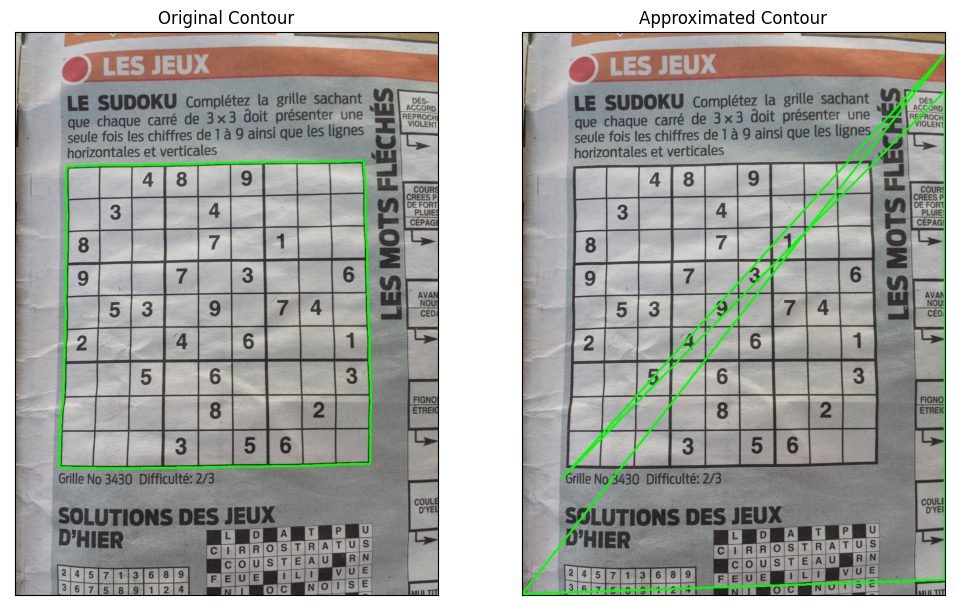

error: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/imgwarp.cpp:3528: error: (-215:Assertion failed) src.checkVector(2, CV_32F) == 4 && dst.checkVector(2, CV_32F) == 4 in function 'getPerspectiveTransform'


In [21]:
start_idx = 0
num_images = 10
train_path = "./train_dataset"
test_path = "./test_dataset"
pattern = r"\.jpg$"

test_filenames = os.listdir(test_path)
test_filenames = [filename for filename in test_filenames if re.search(pattern, filename)]
train_filenames = os.listdir(train_path)
train_filenames = [filename for filename in train_filenames if re.search(pattern, filename)]

for i in range(start_idx, start_idx + num_images):
    # curr_img_path = "./train_dataset/" + train_filenames[i]
    curr_img_path = "./train_dataset/image1078.jpg"
    print(f"{i} | {curr_img_path}")
    result = detectSudokuPuzzle(curr_img_path, False)